In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from entsoe import EntsoePandasClient
from statsmodels.tsa.arima.model import ARIMA

In [75]:
pd.set_option('display.max_columns', None)

In [76]:
my_api_key = os.environ.get('ENTSOE_API_KEY')
client = EntsoePandasClient(api_key=my_api_key)

In [77]:
country_code = 'HU'

country_codes = ['HU', 'AT', 'RO']

In [78]:
def cc_to_tz(country_code):
    dict ={
        'HU': 'Europe/Budapest',
        'AT': 'Europe/Vienna',
        'RO': 'Europe/Bucharest',
    }
    return dict[country_code]

In [79]:
def get_years(time_zone):
    years = []
    start = pd.Timestamp(2018, 12, 25, 0, 0, 0, 0, tz=time_zone)
    end = pd.Timestamp(2018, 12, 31, 23, 59, 59, 999999, tz=time_zone)
    years.append((start, end))
    for year in range(2019, 2024):
        for month in range(1, 13):
            start = pd.Timestamp(year, month, 1, 0, 0, 0, 0, tz=time_zone)
            #add a month to the start date and subtract a second to get the last day of the month
            end = start + pd.DateOffset(months=1) - pd.Timedelta(seconds=1)
            years.append((start, end))
    for month in range(1, 10):
        start = pd.Timestamp(2024, month, 1, 0, 0, 0, 0, tz=time_zone)
        end = start + pd.DateOffset(months=1) - pd.Timedelta(seconds=1)
        years.append((start, end))
    return years

In [80]:
years_dict = {}
years_dict['HU'] = get_years(cc_to_tz('HU'))
years_dict['AT'] = get_years(cc_to_tz('AT'))
years_dict['RO'] = get_years(cc_to_tz('RO'))

In [81]:
prices_folder_path = './data2/prices'
loads_folder_path = './data2/loads'
wind_solar_forecast_folder_path = './data2/wind_solar_forecast'
weather_folder_path = './data2/weather'
base_folder_path = './data2/base'

In [82]:
def get_base_df_filename(country_code, years):
    return f'{base_folder_path}/base_price_{str(years[0][0])[:10]}_{str(years[-1][-1])[:10]}_{country_code}.csv'

def get_base_load_df_filename(country_code, years):
    return f'{base_folder_path}/base_load_{str(years[0][0])[:10]}_{str(years[-1][-1])[:10]}_{country_code}.csv'

def get_prices_df_filename(country_code, years):
    year = years[0][0].year
    month = years[0][0].month
    return f'{prices_folder_path}/{year}/{month}/prices_{year}_{month}_{country_code}.csv'

def get_load_df_filename(country_code, years):
    year = years[0][0].year
    month = years[0][0].month
    return f'{loads_folder_path}/{year}/{month}/base_load_{year}_{month}_{country_code}.csv'

def get_base_wind_solar_forecast_df_filename(country_code, years):
    year = years[0][0].year
    month = years[0][0].month
    return f'{wind_solar_forecast_folder_path}/{year}/{month}/base_wind_solar_forecast_{year}_{month}_{country_code}.csv'

def get_base_weather_df_filename(country_code, years):
    year = years[0][0].year
    month = years[0][0].month
    return f'{weather_folder_path}/{year}/{month}/base_weather_{year}_{month}_{country_code}.csv'

## Querries

In [83]:
def run_querry_day_ahead_prices(country_code, start_date, end_date):
    filename = get_prices_df_filename(country_code, [(start_date, end_date)])

    #convert to utc
    start_ts = start_date.tz_convert('UTC')
    end_ts = end_date.tz_convert('UTC')

    if os.path.exists(filename):
        print(f'{filename} exists, reading from file')
        #load
        df = pd.read_csv(filename, index_col=0)
    else:
        folders = filename.split('/')
        folders = folders[:-1]
        folders = '/'.join(folders)
        if not os.path.exists(folders):
            os.makedirs(folders)

        print(f'{filename} does not exist, downloading from ENTSO-E')

        df = client.query_day_ahead_prices(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E

        df = df.to_frame()

        #rename column named 0 to Prices
        df = df.rename(columns={0: f'Prices_{country_code}'})
        df['Datetime'] = df.index
        df['Datetime_UTC'] = df['Datetime'].dt.tz_convert('UTC')
        df.drop(columns=['Datetime'], inplace=True)
        df = df.reset_index(drop=True)
        
        df.to_csv(filename)

    return df

In [84]:
def run_querry_load(country_code, start_date, end_date):
    filename = get_load_df_filename(country_code, [(start_date, end_date)])

    #convert to utc
    start_ts = start_date.tz_convert('UTC')
    end_ts = end_date.tz_convert('UTC')

    if os.path.exists(filename):
        print(f'{filename} exists, reading from file')
        #load
        df = pd.read_csv(filename, index_col=0)
    else:
        folders = filename.split('/')
        folders = folders[:-1]
        folders = '/'.join(folders)
        if not os.path.exists(folders):
            os.makedirs(folders)

        print(f'{filename} does not exist, downloading from ENTSO-E')

        df = client.query_load(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E

        #rename column named 0 to Load
        df = df.rename(columns={0: f'Load_{country_code}'})
        df['Datetime'] = df.index
        df['Datetime_UTC'] = df['Datetime'].dt.tz_convert('UTC')
        df.drop(columns=['Datetime'], inplace=True)
        df = df.reset_index(drop=True)
        
        df.to_csv(filename)

    return df

In [85]:
def run_querry_wind_solar_forecast(country_code, start_date, end_date):
    filename = get_base_wind_solar_forecast_df_filename(country_code, [(start_date, end_date)])

    #convert to utc
    start_ts = start_date.tz_convert('UTC')
    end_ts = end_date.tz_convert('UTC')

    if os.path.exists(filename):
        print(f'{filename} exists, reading from file')
        #load
        df = pd.read_csv(filename, index_col=0)
    else:
        folders = filename.split('/')
        folders = folders[:-1]
        folders = '/'.join(folders)
        if not os.path.exists(folders):
            os.makedirs(folders)

        print(f'{filename} does not exist, downloading from ENTSO-E')

        df = client.query_wind_and_solar_forecast(country_code, start=start_ts, end=end_ts)        # Data from ENTSO-E

        df = df.rename(columns={0: f'Wind_{country_code}', 1: f'Solar_{country_code}'})
        df['Datetime'] = df.index
        df['Datetime_UTC'] = df['Datetime'].dt.tz_convert('UTC')
        df.drop(columns=['Datetime'], inplace=True)
        df = df.reset_index(drop=True)
        
        df.to_csv(filename)

    return df

## Bases

In [86]:
def get_base_prices(country_code, years_dict):
    years = years_dict[country_code]
    print(years)
    base_df_filename = get_base_df_filename(country_code, years)
    if os.path.exists(base_df_filename):
        print(f'{base_df_filename} exists, reading from file')
        df = pd.read_csv(base_df_filename, index_col=0)
    else:
        print(f'{base_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:
            df_temp = run_querry_day_ahead_prices(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])
        df['Datetime_UTC'] = pd.to_datetime(df['Datetime_UTC'], utc=True)
        df.to_csv(base_df_filename)
    return df

In [87]:
def get_base_load(country_code, years_dict):
    years = years_dict[country_code]
    print(years)
    base_df_filename = get_base_load_df_filename(country_code, years)
    if os.path.exists(base_df_filename):
        print(f'{base_df_filename} exists, reading from file')
        df = pd.read_csv(base_df_filename, index_col=0)
    else:
        print(f'{base_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:
            df_temp = run_querry_load(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])
        df['Datetime_UTC'] = pd.to_datetime(df['Datetime_UTC'], utc=True)
        df.to_csv(base_df_filename)
    return df

In [88]:
def get_base_wind_solar(country_code, years_dict):
    years = years_dict[country_code]
    print(years)
    base_df_filename = get_base_wind_solar_forecast_df_filename(country_code, years)
    if os.path.exists(base_df_filename):
        print(f'{base_df_filename} exists, reading from file')
        df = pd.read_csv(base_df_filename, index_col=0)
        df = df.rename(columns={'Wind': f'Wind_{country_code}', 'Solar': f'Solar_{country_code}'})
    else:
        print(f'{base_df_filename} does not exist, concatenating from multiple files')

        for (start_date, end_date) in years:
            df_temp = run_querry_wind_solar_forecast(country_code, start_date, end_date)

            df = df_temp if (start_date, end_date) == years[0] else pd.concat([df, df_temp])
        df['Datetime_UTC'] = pd.to_datetime(df['Datetime_UTC'], utc=True)
        df.to_csv(base_df_filename)
    return df

## All bases

In [89]:
def get_all_base_prices(country_codes, year_dict):
    for cc in country_codes:
        df_temp = get_base_prices(cc, year_dict)
        df_temp['Datetime_UTC'] = pd.to_datetime(df_temp['Datetime_UTC'], utc=True)
        df = df_temp if cc == country_codes[0] else pd.merge(df, df_temp, on='Datetime_UTC', how='outer')
    return df

In [90]:
def get_all_base_loads(country_codes, year_dict):
    for cc in country_codes:
        df_temp = get_base_load(cc, year_dict)
        # rename columns as {'Actual Load': f'Actual_load_{cc}', 'Datetime_UTC': 'Datetime_UTC'}
        df_temp = df_temp.rename(columns={'Actual Load': f'Actual_load_{cc}'})
        df_temp['Datetime_UTC'] = pd.to_datetime(df_temp['Datetime_UTC'], utc=True)
        df = df_temp if cc == country_codes[0] else pd.merge(df, df_temp, on='Datetime_UTC', how='outer')
    return df

In [91]:
def get_all_base_wind_solar(country_codes, year_dict):
    for cc in country_codes:
        df_temp = get_base_wind_solar(cc, year_dict)
        df_temp = df_temp.rename(columns={'Wind Onshore': f'Wind_onshore_{cc}', 'Solar': f'Solar_{cc}', 'Datetime_UTC': 'Datetime_UTC'})
        df_temp['Datetime_UTC'] = pd.to_datetime(df_temp['Datetime_UTC'], utc=True)
        df = df_temp if cc == country_codes[0] else pd.merge(df, df_temp, on='Datetime_UTC', how='outer')
        
    return df

In [92]:
# create from 15min to hourly by mean, min, max, sum, std, median, var
def col_15min_to_hourly(df, columns):
    df['Datetime_UTC'] = pd.to_datetime(df['Datetime_UTC'], utc=True)
    df = df.set_index('Datetime_UTC')
    df = df.resample('H').agg({columns: ['mean', 'min', 'max', 'sum', 'std', 'median', 'var']})
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.reset_index()
    return df

# Datas


In [93]:
df_prices = get_all_base_prices(['HU', 'AT', 'RO'], years_dict)

[(Timestamp('2018-12-25 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2018-12-31 23:59:59.999999+0100', tz='Europe/Budapest')), (Timestamp('2019-01-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-01-31 23:59:59+0100', tz='Europe/Budapest')), (Timestamp('2019-02-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-02-28 23:59:59+0100', tz='Europe/Budapest')), (Timestamp('2019-03-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-03-31 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-04-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-04-30 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-05-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-05-31 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-06-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-06-30 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-07-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-07-31 23:59:59+0200', tz='Europe/Budapest')), 

In [94]:
# fill na in hu 2023-06-20 with arima
df_load_hu_2023_06 = pd.read_csv('./data2/loads/2023/6/base_load_2023_6_HU.csv', index_col=0)
df_load_hu_2023_06['Datetime_UTC'] = pd.to_datetime(df_load_hu_2023_06['Datetime_UTC'], utc=True)
df_load_hu_2023_06

,Actual Load,Datetime_UTC
0,4403.0,2023-05-31 22:00:00+00:00
1,4333.0,2023-05-31 22:15:00+00:00
2,4300.0,2023-05-31 22:30:00+00:00
3,4224.0,2023-05-31 22:45:00+00:00
4,4187.0,2023-05-31 23:00:00+00:00
...,...,...
2963,4911.0,2023-06-30 20:45:00+00:00
2964,4870.0,2023-06-30 21:00:00+00:00
2965,4829.0,2023-06-30 21:15:00+00:00
2966,4786.0,2023-06-30 21:30:00+00:00


In [95]:
df_load_hu_in = df_load_hu_2023_06[df_load_hu_2023_06['Datetime_UTC'] < '2023-06-20 22:00:00+00:00']

In [96]:
model = ARIMA(df_load_hu_in['Actual Load'], order=(1,0,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=8)
forecast

2008    4997.672574
2009    4992.122321
2010    4986.617769
2011    4981.158543
2012    4975.744270
2013    4970.374579
2014    4965.049103
2015    4959.767478
Name: predicted_mean, dtype: float64

In [97]:
# create a new df with the forecasted values, freq 15 mins
df_forecast = pd.DataFrame()
df_forecast['Actual Load'] = forecast
df_forecast['Datetime_UTC'] = pd.date_range(start='2023-06-20 20:00:00+00:00', periods=8, freq='15min')
df_forecast['Datetime_UTC'] = pd.to_datetime(df_forecast['Datetime_UTC'], utc=True)
df_forecast

,Actual Load,Datetime_UTC
2008,4997.672574,2023-06-20 20:00:00+00:00
2009,4992.122321,2023-06-20 20:15:00+00:00
2010,4986.617769,2023-06-20 20:30:00+00:00
2011,4981.158543,2023-06-20 20:45:00+00:00
2012,4975.744270,2023-06-20 21:00:00+00:00
2013,4970.374579,2023-06-20 21:15:00+00:00
2014,4965.049103,2023-06-20 21:30:00+00:00
2015,4959.767478,2023-06-20 21:45:00+00:00


In [98]:
# merge the forecasted values with the original df
df_load_hu_2023_06_new = pd.concat([df_load_hu_2023_06, df_forecast])
df_load_hu_2023_06_new['Datetime_UTC' ] = pd.to_datetime(df_load_hu_2023_06_new['Datetime_UTC'], utc=True)

# sort the df
df_load_hu_2023_06_new = df_load_hu_2023_06_new.sort_values(by='Datetime_UTC')
# reset index
df_load_hu_2023_06_new = df_load_hu_2023_06_new.reset_index(drop=True)
df_load_hu_2023_06_new

,Actual Load,Datetime_UTC
0,4403.0,2023-05-31 22:00:00+00:00
1,4333.0,2023-05-31 22:15:00+00:00
2,4300.0,2023-05-31 22:30:00+00:00
3,4224.0,2023-05-31 22:45:00+00:00
4,4187.0,2023-05-31 23:00:00+00:00
...,...,...
2971,4911.0,2023-06-30 20:45:00+00:00
2972,4870.0,2023-06-30 21:00:00+00:00
2973,4829.0,2023-06-30 21:15:00+00:00
2974,4786.0,2023-06-30 21:30:00+00:00


In [99]:
# write the new df to a csv
df_load_hu_2023_06_new.to_csv('./data2/loads/2023/6/base_load_2023_6_HU.csv')

In [100]:
df_loads = get_all_base_loads(['HU', 'AT', 'RO'], years_dict)
df_loads_hourly = col_15min_to_hourly(df_loads, 'Actual_load_HU')
df_loads_hourly

[(Timestamp('2018-12-25 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2018-12-31 23:59:59.999999+0100', tz='Europe/Budapest')), (Timestamp('2019-01-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-01-31 23:59:59+0100', tz='Europe/Budapest')), (Timestamp('2019-02-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-02-28 23:59:59+0100', tz='Europe/Budapest')), (Timestamp('2019-03-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-03-31 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-04-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-04-30 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-05-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-05-31 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-06-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-06-30 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-07-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-07-31 23:59:59+0200', tz='Europe/Budapest')), 

C:\Users\proha\AppData\Local\Temp\ipykernel_22344\3590970177.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').agg({columns: ['mean', 'min', 'max', 'sum', 'std', 'median', 'var']})


,Datetime_UTC,Actual_load_HU_mean,Actual_load_HU_min,Actual_load_HU_max,Actual_load_HU_sum,Actual_load_HU_std,Actual_load_HU_median,Actual_load_HU_var
0,2018-12-24 22:00:00+00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,2018-12-24 23:00:00+00:00,3812.75,3743.0,3897.0,15251.0,68.441581,3805.5,4684.250000
2,2018-12-25 00:00:00+00:00,3682.75,3584.0,3754.0,14731.0,72.614852,3696.5,5272.916667
3,2018-12-25 01:00:00+00:00,3475.00,3413.0,3534.0,13900.0,54.289348,3476.5,2947.333333
4,2018-12-25 02:00:00+00:00,3349.50,3321.0,3377.0,13398.0,23.388031,3350.0,547.000000
...,...,...,...,...,...,...,...,...
50563,2024-09-30 17:00:00+00:00,5892.00,5870.0,5905.0,188544.0,13.949217,5896.5,194.580645
50564,2024-09-30 18:00:00+00:00,5687.75,5563.0,5806.0,182008.0,92.183198,5691.0,8497.741935
50565,2024-09-30 19:00:00+00:00,5299.00,5149.0,5436.0,169568.0,108.795161,5305.5,11836.387097
50566,2024-09-30 20:00:00+00:00,4993.00,4916.0,5071.0,159776.0,57.782685,4992.5,3338.838710


In [101]:
df_wind_solar = get_all_base_wind_solar(['HU', 'AT', 'RO'], years_dict)
df_wind_solar_hourly = col_15min_to_hourly(df_wind_solar, 'Wind_onshore_HU')
df_wind_solar_hourly

[(Timestamp('2018-12-25 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2018-12-31 23:59:59.999999+0100', tz='Europe/Budapest')), (Timestamp('2019-01-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-01-31 23:59:59+0100', tz='Europe/Budapest')), (Timestamp('2019-02-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-02-28 23:59:59+0100', tz='Europe/Budapest')), (Timestamp('2019-03-01 00:00:00+0100', tz='Europe/Budapest'), Timestamp('2019-03-31 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-04-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-04-30 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-05-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-05-31 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-06-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-06-30 23:59:59+0200', tz='Europe/Budapest')), (Timestamp('2019-07-01 00:00:00+0200', tz='Europe/Budapest'), Timestamp('2019-07-31 23:59:59+0200', tz='Europe/Budapest')), 

C:\Users\proha\AppData\Local\Temp\ipykernel_22344\3590970177.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').agg({columns: ['mean', 'min', 'max', 'sum', 'std', 'median', 'var']})


,Datetime_UTC,Wind_onshore_HU_mean,Wind_onshore_HU_min,Wind_onshore_HU_max,Wind_onshore_HU_sum,Wind_onshore_HU_std,Wind_onshore_HU_median,Wind_onshore_HU_var
0,2018-12-24 22:00:00+00:00,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,2018-12-24 23:00:00+00:00,183.25,164.0,206.0,733.0,17.839563,181.5,318.250000
2,2018-12-25 00:00:00+00:00,229.00,212.0,241.0,916.0,12.192894,231.5,148.666667
3,2018-12-25 01:00:00+00:00,213.00,202.0,225.0,852.0,9.831921,212.5,96.666667
4,2018-12-25 02:00:00+00:00,207.75,202.0,211.0,831.0,3.947573,209.0,15.583333
...,...,...,...,...,...,...,...,...
50563,2024-09-30 17:00:00+00:00,22.00,21.0,23.0,704.0,0.718421,22.0,0.516129
50564,2024-09-30 18:00:00+00:00,24.00,23.0,25.0,768.0,0.718421,24.0,0.516129
50565,2024-09-30 19:00:00+00:00,26.25,25.0,27.0,840.0,0.842424,26.5,0.709677
50566,2024-09-30 20:00:00+00:00,28.00,27.0,29.0,896.0,0.718421,28.0,0.516129


In [102]:
# merge all dataframes
df = pd.merge(df_prices, df_loads_hourly, on='Datetime_UTC', how='outer')
df = pd.merge(df, df_wind_solar_hourly, on='Datetime_UTC', how='outer')

In [103]:
df

,Prices_HU,Datetime_UTC,Prices_AT,Prices_RO,Actual_load_HU_mean,Actual_load_HU_min,Actual_load_HU_max,Actual_load_HU_sum,Actual_load_HU_std,Actual_load_HU_median,Actual_load_HU_var,Wind_onshore_HU_mean,Wind_onshore_HU_min,Wind_onshore_HU_max,Wind_onshore_HU_sum,Wind_onshore_HU_std,Wind_onshore_HU_median,Wind_onshore_HU_var
0,NaN,2018-12-24 22:00:00+00:00,NaN,45.18,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,27.34,2018-12-24 23:00:00+00:00,30.06,92.00,3812.75,3743.0,3897.0,15251.0,68.441581,3805.5,4684.250000,183.25,164.0,206.0,733.0,17.839563,181.5,318.250000
2,20.99,2018-12-25 00:00:00+00:00,10.06,49.94,3682.75,3584.0,3754.0,14731.0,72.614852,3696.5,5272.916667,229.00,212.0,241.0,916.0,12.192894,231.5,148.666667
3,12.36,2018-12-25 01:00:00+00:00,9.51,45.18,3475.00,3413.0,3534.0,13900.0,54.289348,3476.5,2947.333333,213.00,202.0,225.0,852.0,9.831921,212.5,96.666667
4,10.93,2018-12-25 02:00:00+00:00,11.37,49.94,3349.50,3321.0,3377.0,13398.0,23.388031,3350.0,547.000000,207.75,202.0,211.0,831.0,3.947573,209.0,15.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50563,171.19,2024-09-30 17:00:00+00:00,102.28,171.19,5892.00,5870.0,5905.0,188544.0,13.949217,5896.5,194.580645,22.00,21.0,23.0,704.0,0.718421,22.0,0.516129
50564,113.24,2024-09-30 18:00:00+00:00,71.94,118.22,5687.75,5563.0,5806.0,182008.0,92.183198,5691.0,8497.741935,24.00,23.0,25.0,768.0,0.718421,24.0,0.516129
50565,59.95,2024-09-30 19:00:00+00:00,44.99,60.50,5299.00,5149.0,5436.0,169568.0,108.795161,5305.5,11836.387097,26.25,25.0,27.0,840.0,0.842424,26.5,0.709677
50566,50.81,2024-09-30 20:00:00+00:00,37.33,50.81,4993.00,4916.0,5071.0,159776.0,57.782685,4992.5,3338.838710,28.00,27.0,29.0,896.0,0.718421,28.0,0.516129


In [104]:
df = df[df['Datetime_UTC'] >= '2019-12-25']
df.reset_index(drop=True, inplace=True)

In [105]:
df.isna().sum()

Prices_HU                 0
Datetime_UTC              0
Prices_AT                 0
Prices_RO                 1
Actual_load_HU_mean       0
Actual_load_HU_min        0
Actual_load_HU_max        0
Actual_load_HU_sum        0
Actual_load_HU_std        0
Actual_load_HU_median     0
Actual_load_HU_var        0
Wind_onshore_HU_mean      0
Wind_onshore_HU_min       0
Wind_onshore_HU_max       0
Wind_onshore_HU_sum       0
Wind_onshore_HU_std       0
Wind_onshore_HU_median    0
Wind_onshore_HU_var       0
dtype: int64

# Fill nan

In [106]:
df_ro = df['Prices_RO']
df_ro

0         40.00
1         19.18
2         10.00
3          8.25
4         16.27
          ...  
41801    171.19
41802    118.22
41803     60.50
41804     50.81
41805       NaN
Name: Prices_RO, Length: 41806, dtype: float64

In [107]:
df_ro_in = df_ro.dropna()[:-1]
df_ro_in

0         40.00
1         19.18
2         10.00
3          8.25
4         16.27
          ...  
41799    120.00
41800    141.32
41801    171.19
41802    118.22
41803     60.50
Name: Prices_RO, Length: 41804, dtype: float64

In [108]:
model = ARIMA(df_ro_in, order=(1, 0, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=1)
forecast

41804    54.724242
dtype: float64

In [109]:
model = ARIMA(df_ro, order=(1, 0, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=1)
forecast

41806    64.996853
dtype: float64

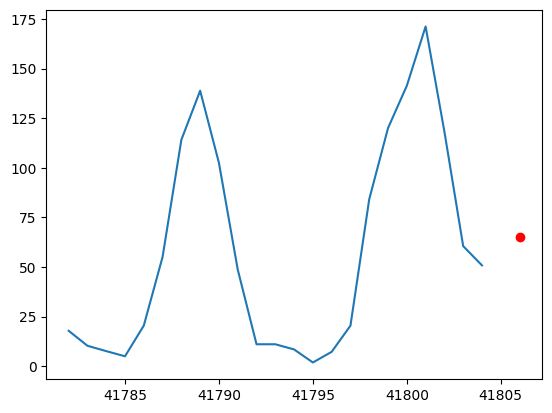

In [110]:
# plot the last 24 value
plt.plot(df_ro[-24:])
plt.plot(forecast, color='red', marker='o')

In [111]:
df[df['Prices_RO'].isna()]

,Prices_HU,Datetime_UTC,Prices_AT,Prices_RO,Actual_load_HU_mean,Actual_load_HU_min,Actual_load_HU_max,Actual_load_HU_sum,Actual_load_HU_std,Actual_load_HU_median,Actual_load_HU_var,Wind_onshore_HU_mean,Wind_onshore_HU_min,Wind_onshore_HU_max,Wind_onshore_HU_sum,Wind_onshore_HU_std,Wind_onshore_HU_median,Wind_onshore_HU_var
41805,9.84,2024-09-30 21:00:00+00:00,9.84,NaN,4841.0,4758.0,4926.0,77456.0,62.456385,4840.0,3900.8,29.75,29.0,30.0,476.0,0.447214,30.0,0.2


In [112]:
df

,Prices_HU,Datetime_UTC,Prices_AT,Prices_RO,Actual_load_HU_mean,Actual_load_HU_min,Actual_load_HU_max,Actual_load_HU_sum,Actual_load_HU_std,Actual_load_HU_median,Actual_load_HU_var,Wind_onshore_HU_mean,Wind_onshore_HU_min,Wind_onshore_HU_max,Wind_onshore_HU_sum,Wind_onshore_HU_std,Wind_onshore_HU_median,Wind_onshore_HU_var
0,8.38,2019-12-25 00:00:00+00:00,20.03,40.00,3563.60,3486.0,3605.0,71272.0,45.549741,3575.0,2074.778947,12.60,8.0,20.0,252.0,5.092823,10.0,25.936842
1,4.02,2019-12-25 01:00:00+00:00,15.84,19.18,3360.60,3285.0,3409.0,67212.0,49.793680,3374.0,2479.410526,40.00,30.0,71.0,800.0,16.065655,33.0,258.105263
2,2.10,2019-12-25 02:00:00+00:00,11.96,10.00,3243.00,3218.0,3263.0,64860.0,19.238120,3246.0,370.105263,64.00,58.0,69.0,1280.0,4.633971,64.0,21.473684
3,1.73,2019-12-25 03:00:00+00:00,10.07,8.25,3247.60,3229.0,3295.0,64952.0,26.178336,3231.0,685.305263,58.80,54.0,66.0,1176.0,4.175114,59.0,17.431579
4,3.41,2019-12-25 04:00:00+00:00,16.67,16.27,3370.20,3336.0,3422.0,67404.0,34.460656,3363.0,1187.536842,79.20,72.0,92.0,1584.0,7.957783,76.0,63.326316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41801,171.19,2024-09-30 17:00:00+00:00,102.28,171.19,5892.00,5870.0,5905.0,188544.0,13.949217,5896.5,194.580645,22.00,21.0,23.0,704.0,0.718421,22.0,0.516129
41802,113.24,2024-09-30 18:00:00+00:00,71.94,118.22,5687.75,5563.0,5806.0,182008.0,92.183198,5691.0,8497.741935,24.00,23.0,25.0,768.0,0.718421,24.0,0.516129
41803,59.95,2024-09-30 19:00:00+00:00,44.99,60.50,5299.00,5149.0,5436.0,169568.0,108.795161,5305.5,11836.387097,26.25,25.0,27.0,840.0,0.842424,26.5,0.709677
41804,50.81,2024-09-30 20:00:00+00:00,37.33,50.81,4993.00,4916.0,5071.0,159776.0,57.782685,4992.5,3338.838710,28.00,27.0,29.0,896.0,0.718421,28.0,0.516129


In [113]:
df.at[df[df['Prices_RO'].isna()].index[0], 'Prices_RO'] = forecast

C:\Users\proha\AppData\Local\Temp\ipykernel_22344\1991604371.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df.at[df[df['Prices_RO'].isna()].index[0], 'Prices_RO'] = forecast


In [114]:
df

,Prices_HU,Datetime_UTC,Prices_AT,Prices_RO,Actual_load_HU_mean,Actual_load_HU_min,Actual_load_HU_max,Actual_load_HU_sum,Actual_load_HU_std,Actual_load_HU_median,Actual_load_HU_var,Wind_onshore_HU_mean,Wind_onshore_HU_min,Wind_onshore_HU_max,Wind_onshore_HU_sum,Wind_onshore_HU_std,Wind_onshore_HU_median,Wind_onshore_HU_var
0,8.38,2019-12-25 00:00:00+00:00,20.03,40.000000,3563.60,3486.0,3605.0,71272.0,45.549741,3575.0,2074.778947,12.60,8.0,20.0,252.0,5.092823,10.0,25.936842
1,4.02,2019-12-25 01:00:00+00:00,15.84,19.180000,3360.60,3285.0,3409.0,67212.0,49.793680,3374.0,2479.410526,40.00,30.0,71.0,800.0,16.065655,33.0,258.105263
2,2.10,2019-12-25 02:00:00+00:00,11.96,10.000000,3243.00,3218.0,3263.0,64860.0,19.238120,3246.0,370.105263,64.00,58.0,69.0,1280.0,4.633971,64.0,21.473684
3,1.73,2019-12-25 03:00:00+00:00,10.07,8.250000,3247.60,3229.0,3295.0,64952.0,26.178336,3231.0,685.305263,58.80,54.0,66.0,1176.0,4.175114,59.0,17.431579
4,3.41,2019-12-25 04:00:00+00:00,16.67,16.270000,3370.20,3336.0,3422.0,67404.0,34.460656,3363.0,1187.536842,79.20,72.0,92.0,1584.0,7.957783,76.0,63.326316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41801,171.19,2024-09-30 17:00:00+00:00,102.28,171.190000,5892.00,5870.0,5905.0,188544.0,13.949217,5896.5,194.580645,22.00,21.0,23.0,704.0,0.718421,22.0,0.516129
41802,113.24,2024-09-30 18:00:00+00:00,71.94,118.220000,5687.75,5563.0,5806.0,182008.0,92.183198,5691.0,8497.741935,24.00,23.0,25.0,768.0,0.718421,24.0,0.516129
41803,59.95,2024-09-30 19:00:00+00:00,44.99,60.500000,5299.00,5149.0,5436.0,169568.0,108.795161,5305.5,11836.387097,26.25,25.0,27.0,840.0,0.842424,26.5,0.709677
41804,50.81,2024-09-30 20:00:00+00:00,37.33,50.810000,4993.00,4916.0,5071.0,159776.0,57.782685,4992.5,3338.838710,28.00,27.0,29.0,896.0,0.718421,28.0,0.516129


In [115]:
df.isna().sum()

Prices_HU                 0
Datetime_UTC              0
Prices_AT                 0
Prices_RO                 0
Actual_load_HU_mean       0
Actual_load_HU_min        0
Actual_load_HU_max        0
Actual_load_HU_sum        0
Actual_load_HU_std        0
Actual_load_HU_median     0
Actual_load_HU_var        0
Wind_onshore_HU_mean      0
Wind_onshore_HU_min       0
Wind_onshore_HU_max       0
Wind_onshore_HU_sum       0
Wind_onshore_HU_std       0
Wind_onshore_HU_median    0
Wind_onshore_HU_var       0
dtype: int64

# Weather

In [116]:
#create a filenames list for the weather data
weather_filenames = os.listdir(weather_folder_path)

#concat the weather data
for weather_filename in weather_filenames:
    if weather_filename == weather_filenames[0]:
        df_weather = pd.read_csv(f'{weather_folder_path}/{weather_filename}', index_col=0)
    else:
        df_temp = pd.read_csv(f'{weather_folder_path}/{weather_filename}', index_col=0)
        df_weather = pd.concat([df_weather, df_temp])


In [117]:
df_weather['Datetime_UTC'] = df_weather.index
df_weather['Datetime_UTC'] = pd.to_datetime(df_weather['Datetime_UTC'], utc=True)
df_weather = df_weather.reset_index(drop=True)

In [118]:
df_weather

,temperature_2m_BP,relative_humidity_2m_BP,pressure_msl_BP,surface_pressure_BP,precipitation_BP,rain_BP,cloud_cover_BP,cloud_cover_low_BP,cloud_cover_mid_BP,cloud_cover_high_BP,shortwave_radiation_BP,direct_radiation_BP,diffuse_radiation_BP,sunshine_duration_BP,wind_speed_10m_BP,wind_speed_100m_BP,wind_direction_10m_BP,wind_direction_100m_BP,wind_gusts_10m_BP,temperature_2m_Konstanca,relative_humidity_2m_Konstanca,pressure_msl_Konstanca,surface_pressure_Konstanca,precipitation_Konstanca,rain_Konstanca,cloud_cover_Konstanca,cloud_cover_low_Konstanca,cloud_cover_mid_Konstanca,cloud_cover_high_Konstanca,shortwave_radiation_Konstanca,direct_radiation_Konstanca,diffuse_radiation_Konstanca,sunshine_duration_Konstanca,wind_speed_10m_Konstanca,wind_speed_100m_Konstanca,wind_direction_10m_Konstanca,wind_direction_100m_Konstanca,wind_gusts_10m_Konstanca,Datetime_UTC
0,-1.579,89.836760,1031.0,1016.21246,0.0,0.0,17.1,5.0,1.0,40.0,0.0,0.0,0.0,0.0,6.109403,10.895577,315.000100,352.405430,11.159999,0.215500,93.328880,1027.5,1020.21160,0.0,0.0,14.400000,12.0,6.0,0.0,0.0,0.0,0.0,0.0,10.105681,20.326454,355.914460,22.932130,16.199999,2019-01-01 00:00:00+00:00
1,-1.579,89.836760,1031.1,1016.31100,0.0,0.0,5.4,5.0,0.0,3.0,0.0,0.0,0.0,0.0,5.991594,10.315115,302.735200,330.751280,11.879999,0.665500,94.718620,1028.1,1020.81920,0.0,0.0,29.100000,21.0,17.0,0.0,0.0,0.0,0.0,0.0,11.212135,22.862123,5.527458,26.161512,19.440000,2019-01-01 01:00:00+00:00
2,-1.879,90.484474,1031.2,1016.39350,0.0,0.0,7.8,8.0,1.0,0.0,0.0,0.0,0.0,0.0,6.120000,10.195057,298.072400,317.862460,10.799999,0.965500,93.707565,1027.9,1020.62880,0.0,0.0,17.400000,14.0,8.0,0.0,0.0,0.0,0.0,0.0,10.041354,21.370783,14.534496,32.619240,19.080000,2019-01-01 02:00:00+00:00
3,-1.779,89.820750,1030.7,1015.90607,0.0,0.0,5.4,6.0,0.0,0.0,0.0,0.0,0.0,0.0,8.217153,17.826363,298.810700,313.363460,15.119999,0.315500,93.674934,1027.6,1020.31354,0.0,0.0,26.099998,27.0,3.0,0.0,0.0,0.0,0.0,0.0,7.342588,18.218275,11.309895,37.775745,16.919998,2019-01-01 03:00:00+00:00
4,-2.279,90.116875,1030.1,1015.28766,0.0,0.0,29.7,1.0,0.0,96.0,0.0,0.0,0.0,0.0,6.439876,15.546833,296.564970,312.184360,15.119999,-0.134500,93.995240,1027.7,1020.40100,0.0,0.0,42.900000,45.0,4.0,0.0,0.0,0.0,0.0,0.0,7.421590,15.021105,14.036275,45.970932,11.879999,2019-01-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50395,9.521,66.184006,1020.8,1006.72900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.640994,17.024040,316.909150,326.645970,15.119999,9.615500,89.150010,1010.3,1003.37090,1.4,1.4,100.000000,100.0,100.0,88.0,0.0,0.0,0.0,0.0,28.771297,46.328240,305.579440,309.007480,50.039997,2024-09-30 19:00:00+00:00
50396,8.521,72.820656,1020.6,1006.48220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.279395,13.036026,332.700500,342.315520,12.599999,9.565499,89.145950,1010.1,1003.17110,2.0,2.0,100.000000,100.0,100.0,100.0,0.0,0.0,0.0,0.0,30.996084,49.531730,306.736900,310.578600,53.639996,2024-09-30 20:00:00+00:00
50397,7.871,78.544050,1020.2,1006.05550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.582902,10.771461,339.227660,350.380340,10.799999,9.515500,89.141860,1009.5,1002.57390,2.7,2.7,100.000000,99.0,100.0,100.0,0.0,0.0,0.0,0.0,32.497850,51.738020,309.155430,312.179750,56.160000,2024-09-30 21:00:00+00:00
50398,6.721,87.986680,1020.0,1005.80070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.421590,9.292254,22.833694,44.215275,10.080000,9.615500,89.150010,1009.1,1002.17914,2.4,2.4,100.000000,100.0,100.0,100.0,0.0,0.0,0.0,0.0,31.826931,50.800835,307.647670,310.689270,56.160000,2024-09-30 22:00:00+00:00


In [119]:
df = pd.merge(df, df_weather, on='Datetime_UTC', how='inner')

# More in features

In [120]:
target_country_code = 'HU'

In [121]:
df['year'] = df['Datetime_UTC'].dt.year
df['month'] = df['Datetime_UTC'].dt.month
df['day'] = df['Datetime_UTC'].dt.day
df['hour'] = df['Datetime_UTC'].dt.hour
df['dayoftheweek'] = df['Datetime_UTC'].dt.dayofweek
df['date'] = df['Datetime_UTC'].dt.date

In [122]:
df

,Prices_HU,Datetime_UTC,Prices_AT,Prices_RO,Actual_load_HU_mean,Actual_load_HU_min,Actual_load_HU_max,Actual_load_HU_sum,Actual_load_HU_std,Actual_load_HU_median,Actual_load_HU_var,Wind_onshore_HU_mean,Wind_onshore_HU_min,Wind_onshore_HU_max,Wind_onshore_HU_sum,Wind_onshore_HU_std,Wind_onshore_HU_median,Wind_onshore_HU_var,temperature_2m_BP,relative_humidity_2m_BP,pressure_msl_BP,surface_pressure_BP,precipitation_BP,rain_BP,cloud_cover_BP,cloud_cover_low_BP,cloud_cover_mid_BP,cloud_cover_high_BP,shortwave_radiation_BP,direct_radiation_BP,diffuse_radiation_BP,sunshine_duration_BP,wind_speed_10m_BP,wind_speed_100m_BP,wind_direction_10m_BP,wind_direction_100m_BP,wind_gusts_10m_BP,temperature_2m_Konstanca,relative_humidity_2m_Konstanca,pressure_msl_Konstanca,surface_pressure_Konstanca,precipitation_Konstanca,rain_Konstanca,cloud_cover_Konstanca,cloud_cover_low_Konstanca,cloud_cover_mid_Konstanca,cloud_cover_high_Konstanca,shortwave_radiation_Konstanca,direct_radiation_Konstanca,diffuse_radiation_Konstanca,sunshine_duration_Konstanca,wind_speed_10m_Konstanca,wind_speed_100m_Konstanca,wind_direction_10m_Konstanca,wind_direction_100m_Konstanca,wind_gusts_10m_Konstanca,year,month,day,hour,dayoftheweek,date
0,8.38,2019-12-25 00:00:00+00:00,20.03,40.000000,3563.60,3486.0,3605.0,71272.0,45.549741,3575.0,2074.778947,12.60,8.0,20.0,252.0,5.092823,10.0,25.936842,5.021000,85.986800,1011.2,997.03770,0.3,0.3,100.0,100.0,100.0,95.0,0.0,0.0,0.0,0.0,11.165805,20.447239,290.77234,296.11386,24.119999,6.515500,88.584100,1004.6,997.63403,0.5,0.5,100.000000,100.0,100.0,89.0,0.0,0.0,0.0,0.0,20.674156,34.017620,305.07382,309.41736,38.519997,2019,12,25,0,2,2019-12-25
1,4.02,2019-12-25 01:00:00+00:00,15.84,19.180000,3360.60,3285.0,3409.0,67212.0,49.793680,3374.0,2479.410526,40.00,30.0,71.0,800.0,16.065655,33.0,258.105263,4.771000,89.691120,1011.2,997.02515,0.1,0.1,100.0,100.0,99.0,97.0,0.0,0.0,0.0,0.0,8.396570,16.992609,300.96368,306.38446,21.240000,6.415500,84.339226,1004.6,997.63150,0.1,0.1,100.000000,100.0,99.0,95.0,0.0,0.0,0.0,0.0,21.599998,34.713410,306.86996,310.79456,38.160000,2019,12,25,1,2,2019-12-25
2,2.10,2019-12-25 02:00:00+00:00,11.96,10.000000,3243.00,3218.0,3263.0,64860.0,19.238120,3246.0,370.105263,64.00,58.0,69.0,1280.0,4.633971,64.0,21.473684,4.771000,90.966125,1011.2,997.02515,0.1,0.1,100.0,100.0,100.0,98.0,0.0,0.0,0.0,0.0,6.763786,14.904173,295.20108,307.14676,16.919998,6.265500,81.980200,1004.6,997.62780,0.1,0.1,100.000000,76.0,79.0,98.0,0.0,0.0,0.0,0.0,21.252197,34.145008,308.81140,312.43620,38.519997,2019,12,25,2,2,2019-12-25
3,1.73,2019-12-25 03:00:00+00:00,10.07,8.250000,3247.60,3229.0,3295.0,64952.0,26.178336,3231.0,685.305263,58.80,54.0,66.0,1176.0,4.175114,59.0,17.431579,4.921000,90.976560,1011.1,996.93400,0.2,0.2,100.0,100.0,100.0,97.0,0.0,0.0,0.0,0.0,8.311245,17.287498,287.65020,301.37296,16.199999,6.065500,80.517890,1004.7,997.72205,0.0,0.0,98.700005,23.0,81.0,98.0,0.0,0.0,0.0,0.0,20.746122,33.636406,308.65982,312.39740,37.800000,2019,12,25,3,2,2019-12-25
4,3.41,2019-12-25 04:00:00+00:00,16.67,16.270000,3370.20,3336.0,3422.0,67404.0,34.460656,3363.0,1187.536842,79.20,72.0,92.0,1584.0,7.957783,76.0,63.326316,5.021000,90.663864,1011.1,996.93910,0.2,0.2,100.0,99.0,100.0,98.0,0.0,0.0,0.0,0.0,9.793059,19.881649,306.02747,312.06424,19.800000,5.815500,80.197630,1004.8,997.81506,0.0,0.0,100.000000,31.0,74.0,98.0,0.0,0.0,0.0,0.0,19.296135,32.377990,306.65620,311.84506,36.360000,2019,12,25,4,2,2019-12-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41801,171.19,2024-09-30 17:00:00+00:00,102.28,171.190000,5892.00,5870.0,5905.0,188544.0,13.949217,5896.5,194.580645,22.00,21.0,23.0,704.0,0.718421,22.0,0.516129,10.971000,66.268290,1020.6,1006.60284,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,0.0,7.193247,15.951087,301.70140,319.11830,11.520000,

In [123]:
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
dayofweek_dummies = pd.get_dummies(df['dayoftheweek'], prefix='dayofweek', drop_first=True)
df = pd.concat([df, month_dummies, dayofweek_dummies], axis=1)

In [124]:
dummy_columns = month_dummies.columns.tolist() + dayofweek_dummies.columns.tolist()

In [125]:
df['Datetime_UTC-2d'] = df['Datetime_UTC'] + pd.to_timedelta(-2, unit='day')
df['Datetime_UTC-7d'] = df['Datetime_UTC'] + pd.to_timedelta(-7, unit='day')

for country in country_codes:
    load_map = df.set_index('Datetime_UTC')[f'Prices_{country}'].to_dict()

    df[f'Price_2d_{country}'] = df['Datetime_UTC-2d'].map(load_map)
    df[f'Price_7d_{country}'] = df['Datetime_UTC-7d'].map(load_map)

In [126]:
# was the 2 or 7 day before a weekday or not
df['is_weekday'] = df['Datetime_UTC'].dt.dayofweek < 5
df['is_weekday_2d'] = df['Datetime_UTC-2d'].dt.dayofweek < 5
df['is_weekday_7d'] = df['Datetime_UTC-7d'].dt.dayofweek < 5


In [127]:
# 2 and 7 day before [-1..+1] hourly avg price
for country in country_codes:
    df[f'Price_2d_-1h_{country}'] = df[f'Price_2d_{country}'].shift(1)
    df[f'Price_2d_0h_{country}'] = df[f'Price_2d_{country}']
    df[f'Price_2d_+1h_{country}'] = df[f'Price_2d_{country}'].shift(-1)

    df[f'Price_7d_-1h_{country}'] = df[f'Price_7d_{country}'].shift(1)
    df[f'Price_7d_0h_{country}'] = df[f'Price_7d_{country}']
    df[f'Price_7d_+1h_{country}'] = df[f'Price_7d_{country}'].shift(-1)

    # get the average of the 3 hours
    df[f'Price_2d_avg_{country}'] = df[[f'Price_2d_-1h_{country}', f'Price_2d_0h_{country}', f'Price_2d_+1h_{country}']].mean(axis=1)
    df[f'Price_7d_avg_{country}'] = df[[f'Price_7d_-1h_{country}', f'Price_7d_0h_{country}', f'Price_7d_+1h_{country}']].mean(axis=1)

In [128]:
# 2 and 7 day before [-1..+1] hourly Actual_load_{country}_mean
country = target_country_code
load_map = df.set_index('Datetime_UTC')[f'Actual_load_HU_mean'].to_dict()

df[f'Load_2d_-1h_{country}'] = df['Datetime_UTC-2d'].shift(1).map(load_map)
df[f'Load_2d_0h_{country}'] = df['Datetime_UTC-2d'].map(load_map)
df[f'Load_2d_+1h_{country}'] = df['Datetime_UTC-2d'].shift(-1).map(load_map)

df[f'Load_7d_-1h_{country}'] = df['Datetime_UTC-7d'].shift(1).map(load_map)
df[f'Load_7d_0h_{country}'] = df['Datetime_UTC-7d'].map(load_map)
df[f'Load_7d_+1h_{country}'] = df['Datetime_UTC-7d'].shift(-1).map(load_map)

# get the average of the 3 hours
df[f'Load_2d_avg_{country}'] = df[[f'Load_2d_-1h_{country}', f'Load_2d_0h_{country}', f'Load_2d_+1h_{country}']].mean(axis=1)
df[f'Load_7d_avg_{country}'] = df[[f'Load_7d_-1h_{country}', f'Load_7d_0h_{country}', f'Load_7d_+1h_{country}']].mean(axis=1)

In [129]:
from workalendar.europe import Hungary, Romania, Austria

cal_hu = Hungary()
cal_ro = Romania()
cal_at = Austria()
year_list = df['Datetime_UTC'].dt.year.unique()

In [130]:
year_list

array([2019, 2020, 2021, 2022, 2023, 2024])

In [131]:
holiday_df = pd.DataFrame()
for cal, cntry in [(cal_hu, 'HU'), (cal_ro, 'RO'), (cal_at, 'AT')]:
    for year in year_list:
        holidays = cal.holidays(year)
        temp_df = pd.DataFrame(holidays, columns=['date', f'holiday_name_{cntry}'])
        holiday_df = pd.concat([holiday_df, temp_df],
                            axis=0).reset_index(drop=True)

In [132]:
holiday_df

,date,holiday_name_HU,holiday_name_RO,holiday_name_AT
0,2019-01-01,New year,NaN,NaN
1,2019-03-15,National Day,NaN,NaN
2,2019-04-19,Good Friday,NaN,NaN
3,2019-04-21,Easter Sunday,NaN,NaN
4,2019-04-22,Easter Monday,NaN,NaN
...,...,...,...,...
241,2024-10-26,NaN,NaN,National Holiday
242,2024-11-01,NaN,NaN,All Saints Day
243,2024-12-08,NaN,NaN,Immaculate Conception
244,2024-12-25,NaN,NaN,Christmas Day


In [133]:
holiday_df.set_index('date', inplace=True)

In [143]:
for col in holiday_df.columns:
    holiday_map = holiday_df[col].to_dict()

    #replace nan with 0 in holiday_map
    for key in holiday_map.keys():
        if pd.isna(holiday_map[key]):
            holiday_map[key] = 0
    
    # replace not 0 with 1
    for key in holiday_map.keys():
        if holiday_map[key] != 0:
            holiday_map[key] = 1

    cntry = col.split('_')[-1]
    df[f'is_holiday_{cntry}'] = df['date'].map(holiday_map)

    # is_holiday_{country} 2 and 7 days before
    df[f'is_holiday_2d_{cntry}'] = df['Datetime_UTC-2d'].dt.date.map(holiday_map)
    df[f'is_holiday_7d_{cntry}'] = df['Datetime_UTC-7d'].dt.date.map(holiday_map)

    #fill na with 0
    df[f'is_holiday_{cntry}'] = df[f'is_holiday_{cntry}'].fillna(0)
    df[f'is_holiday_2d_{cntry}'] = df[f'is_holiday_2d_{cntry}'].fillna(0)
    df[f'is_holiday_7d_{cntry}'] = df[f'is_holiday_7d_{cntry}'].fillna(0)

In [144]:
for col in holiday_df.columns:
    cntry = col.split('_')[-1]
    df[f'is_workday_{cntry}'] = 1
    df.loc[df[f'is_holiday_{cntry}'] == 1, f'is_workday_{cntry}'] = 0
    df.loc[df['dayoftheweek'].isin([5, 6]), f'is_workday_{cntry}'] = 0

    # is_workday_{country} 2 and 7 days before
    df[f'is_workday_2d_{cntry}'] = 1
    df.loc[df[f'is_holiday_2d_{cntry}'] == 1, f'is_workday_2d_{cntry}'] = 0
    df.loc[df['Datetime_UTC-2d'].dt.dayofweek.isin([5, 6]), f'is_workday_2d_{cntry}'] = 0

    df[f'is_workday_7d_{cntry}'] = 1
    df.loc[df[f'is_holiday_7d_{cntry}'] == 1, f'is_workday_7d_{cntry}'] = 0
    df.loc[df['Datetime_UTC-7d'].dt.dayofweek.isin([5, 6]), f'is_workday_7d_{cntry}'] = 0
    

In [145]:
df

,Prices_HU,Datetime_UTC,Prices_AT,Prices_RO,Actual_load_HU_mean,Actual_load_HU_min,Actual_load_HU_max,Actual_load_HU_sum,Actual_load_HU_std,Actual_load_HU_median,Actual_load_HU_var,Wind_onshore_HU_mean,Wind_onshore_HU_min,Wind_onshore_HU_max,Wind_onshore_HU_sum,Wind_onshore_HU_std,Wind_onshore_HU_median,Wind_onshore_HU_var,temperature_2m_BP,relative_humidity_2m_BP,pressure_msl_BP,surface_pressure_BP,precipitation_BP,rain_BP,cloud_cover_BP,cloud_cover_low_BP,cloud_cover_mid_BP,cloud_cover_high_BP,shortwave_radiation_BP,direct_radiation_BP,diffuse_radiation_BP,sunshine_duration_BP,wind_speed_10m_BP,wind_speed_100m_BP,wind_direction_10m_BP,wind_direction_100m_BP,wind_gusts_10m_BP,temperature_2m_Konstanca,relative_humidity_2m_Konstanca,pressure_msl_Konstanca,surface_pressure_Konstanca,precipitation_Konstanca,rain_Konstanca,cloud_cover_Konstanca,cloud_cover_low_Konstanca,cloud_cover_mid_Konstanca,cloud_cover_high_Konstanca,shortwave_radiation_Konstanca,direct_radiation_Konstanca,diffuse_radiation_Konstanca,sunshine_duration_Konstanca,wind_speed_10m_Konstanca,wind_speed_100m_Konstanca,wind_direction_10m_Konstanca,wind_direction_100m_Konstanca,wind_gusts_10m_Konstanca,year,month,day,hour,dayoftheweek,date,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,Datetime_UTC-2d,Datetime_UTC-7d,Price_2d_HU,Price_7d_HU,Price_2d_AT,Price_7d_AT,Price_2d_RO,Price_7d_RO,is_weekday,is_weekday_2d,is_weekday_7d,Price_2d_-1h_HU,Price_2d_0h_HU,Price_2d_+1h_HU,Price_7d_-1h_HU,Price_7d_0h_HU,Price_7d_+1h_HU,Price_2d_avg_HU,Price_7d_avg_HU,Price_2d_-1h_AT,Price_2d_0h_AT,Price_2d_+1h_AT,Price_7d_-1h_AT,Price_7d_0h_AT,Price_7d_+1h_AT,Price_2d_avg_AT,Price_7d_avg_AT,Price_2d_-1h_RO,Price_2d_0h_RO,Price_2d_+1h_RO,Price_7d_-1h_RO,Price_7d_0h_RO,Price_7d_+1h_RO,Price_2d_avg_RO,Price_7d_avg_RO,Load_2d_-1h_HU,Load_2d_0h_HU,Load_2d_+1h_HU,Load_7d_-1h_HU,Load_7d_0h_HU,Load_7d_+1h_HU,Load_2d_avg_HU,Load_7d_avg_HU,is_holiday_HU,is_holiday_2d_HU,is_holiday_7d_HU,is_holiday_RO,is_holiday_2d_RO,is_holiday_7d_RO,is_holiday_AT,is_holiday_2d_AT,is_holiday_7d_AT,is_workday_HU,is_workday_2d_HU,is_workday_7d_HU,is_workday_RO,is_workday_2d_RO,is_workday_7d_RO,is_workday_AT,is_workday_2d_AT,is_workday_7d_AT
0,8.38,2019-12-25 00:00:00+00:00,20.03,40.000000,3563.60,3486.0,3605.0,71272.0,45.549741,3575.0,2074.778947,12.60,8.0,20.0,252.0,5.092823,10.0,25.936842,5.021000,85.986800,1011.2,997.03770,0.3,0.3,100.0,100.0,100.0,95.0,0.0,0.0,0.0,0.0,11.165805,20.447239,290.77234,296.11386,24.119999,6.515500,88.584100,1004.6,997.63403,0.5,0.5,100.000000,100.0,100.0,89.0,0.0,0.0,0.0,0.0,20.674156,34.017620,305.07382,309.41736,38.519997,2019,12,25,0,2,2019-12-25,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,2019-12-23 00:00:00+00:00,2019-12-18 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1,1,1,1,0,1,1
1,4.02,2019-12-25 01:00:00+00:00,15.84,19.180000,3360.60,3285.0,3409.0,67212.0,49.793680,3374.0,2479.410526,40.00,30.0,71.0,800.0,16.065655,33.0,258.105263,4.771000,89.691120,1011.2,997.02515,0.1,0.1,100.0,100.0,99.0,97.0,0.0,0.0,0.0,0.0,8.396570,16.992609,300.96368,306.38446,21.240000,6.415500,84.339226,1004.6,997.63150,0.1,0.1,100.000000,100.0,99.0,95.0,0.0,0.0,0.0,0.0,21.599998,34.713410,306.86996,310.79456,38.160000,2019,12,25,1,2,2019-12-25,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,2019-12-23 01:00:00+00:00,2019-12-18 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1,1,1,1,0,1,1
2,2.10,2019-12-25 02:00:00+00:00,11.96,10.0000

In [146]:
# save the final dataframe
df.to_csv('./data2/base/base_final.csv')

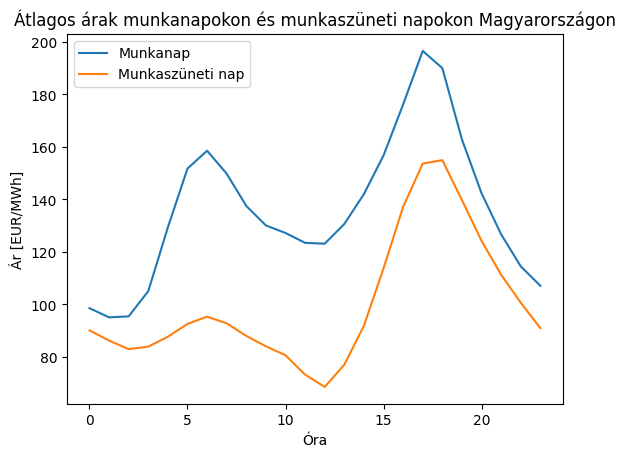

In [147]:
# calculate the average price for every hour of the days where is_workday_hu is 1 and is_workday_hu is 0 and then plot it
df_workday = df[df['is_workday_HU'] == 1]
df_not_wd = df[df['is_workday_HU'] == 0]

df_workday_avg = df_workday.groupby('hour')['Prices_HU'].mean()
df_weekend_avg = df_not_wd.groupby('hour')['Prices_HU'].mean()

plt.plot(df_workday_avg, label='Munkanap')
plt.plot(df_weekend_avg, label='Munkaszüneti nap')

plt.xlabel('Óra')
plt.ylabel('Ár [EUR/MWh]')

plt.title('Átlagos árak munkanapokon és munkaszüneti napokon Magyarországon')

plt.legend()


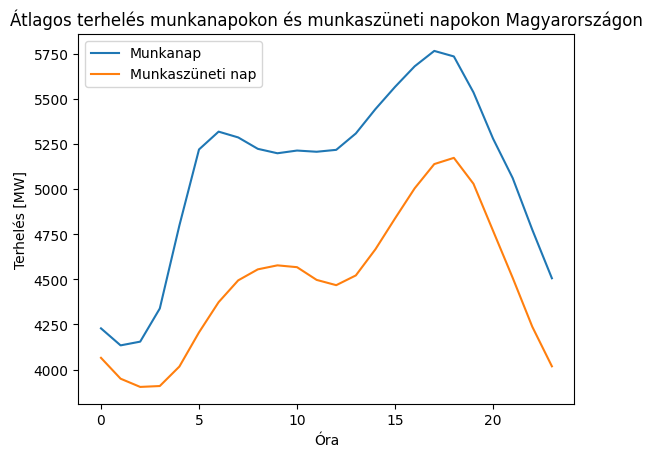

In [148]:
#calculéate the average load for every hour of the days where is_workday_hu is 1 and is_workday_hu is 0 and then plot it
df_workday = df[df['is_workday_HU'] == 1]
df_not_wd = df[df['is_workday_HU'] == 0]

df_workday_avg = df_workday.groupby('hour')['Actual_load_HU_mean'].mean()
df_weekend_avg = df_not_wd.groupby('hour')['Actual_load_HU_mean'].mean()

plt.plot(df_workday_avg, label='Munkanap')
plt.plot(df_weekend_avg, label='Munkaszüneti nap')

plt.xlabel('Óra')
plt.ylabel('Terhelés [MW]')
plt.title('Átlagos terhelés munkanapokon és munkaszüneti napokon Magyarországon')

plt.legend()

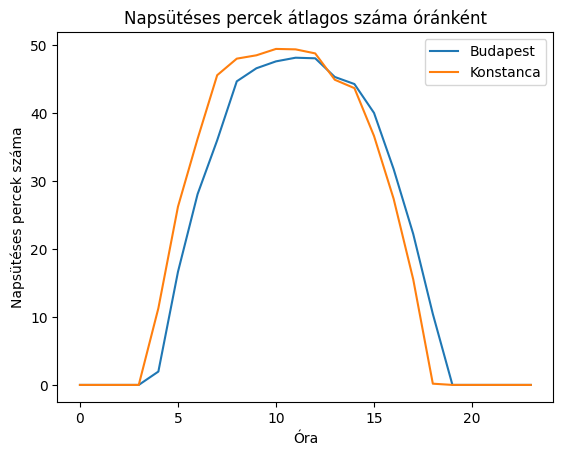

In [149]:
# napi átlagos napsütötte órák száma egy nap magyarországon (sunshine_duration_BP), plot it
df_sunshine = df.groupby('hour')['sunshine_duration_BP'].mean()
df_sunshine_konstanca = df.groupby('hour')['sunshine_duration_Konstanca'].mean()

# devide by 60
df_sunshine = df_sunshine / 60
df_sunshine_konstanca = df_sunshine_konstanca / 60


plt.plot(df_sunshine)
plt.plot(df_sunshine_konstanca)

plt.xlabel('Óra')
plt.ylabel('Napsütéses percek száma')
plt.title('Napsütéses percek átlagos száma óránként')

plt.legend(['Budapest', 'Konstanca'])




In [150]:
df['is_holiday_AT'].value_counts()

is_holiday_AT
0.0    40318
1.0     1488
Name: count, dtype: int64